data.shape: (759, 9)
The minimum loss: 0.4665030241012573


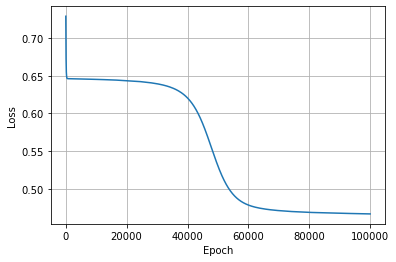

In [91]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# 1、划分训练集和测试集。标签为二分类0 1
data = np.loadtxt('../Data/diabetes.csv.gz', delimiter=',', dtype=np.float32)
print("data.shape:", data.shape)
X_train, X_test, Y_train, Y_test = train_test_split(data[:, :-1], data[:, -1], test_size=0.3, random_state=46)
x_train = torch.tensor(X_train)
y_train = torch.tensor(Y_train).reshape(Y_train.shape[0], 1)  # 转成二维
x_test = torch.tensor(X_test)
y_test = torch.tensor(Y_test).reshape(Y_test.shape[0], 1)


# 2、用类设计模型
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.linear1 = torch.nn.Linear(8, 6)  # 输入维度为8，即特征数。输出维度为6
        self.linear2 = torch.nn.Linear(6, 4)
        self.linear3 = torch.nn.Linear(4, 1)
        self.activate = torch.nn.Sigmoid()

    def forward(self, x):
        x = self.activate(self.linear1(x))
        x = self.activate(self.linear2(x))
        x = self.activate(self.linear3(x))  # 经过三层的变换
        return x


model = Model()

# 3、构造损失和优化器
criterion = torch.nn.BCELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

loss_list = []
# 4、用训练集训练模型
for epoch in range(100000):
    # Forward
    y_pred = model(x_train)
    loss = criterion(y_pred, y_train)
    loss_list.append(loss.item())
    # print(epoch, loss.item())

    # Backward
    optimizer.zero_grad()
    loss.backward()

    # Update
    optimizer.step()

print("The minimum loss:", min(loss_list))
plt.plot(loss_list)
plt.grid()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

上面图像竟然是这样！刚开始epoch只随便设置几千，普普通通没啥意思。后面想着搞点大的，随着次数增多，损失在40000时附近迅速下降，神奇。同学们，探索精神懂不懂呀！

接下来用我们上面训练好的模型来检验其在测试集上的表现：

0.8488888888888889


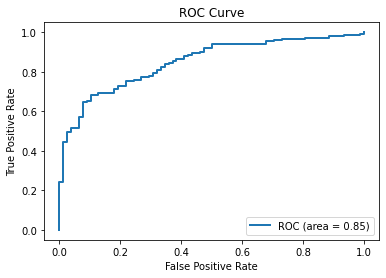

In [96]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
import pandas as pd

y_pred = pd.DataFrame(model(x_test).detach().numpy())
fpr, tpr, thresholds = roc_curve(y_test.numpy(), y_pred, pos_label=1)
print(auc(fpr, tpr))
plt.plot(fpr, tpr, label='ROC (area = {0:.2f})'.format(auc(fpr, tpr)), lw=2)

plt.xlim([-0.05, 1.05])  # 设置x、y轴的上下限，以免和边缘重合，更好地观察图像的整体
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()
# 曲线下方面积越大，模型效果越好。关于ROC曲线涉及混淆矩阵，相关内容以后再补充。

In [93]:
y_pred.head(10)  # 模型返回的是预测y=1的概率

,0
0,0.788377
1,0.582527
2,0.433012
3,0.433163
4,0.901173
5,0.722548
6,0.301493
7,0.923470
8,0.366946
9,0.659431


In [94]:
y_test.numpy()[:10]  # 真实值

array([[1.],
       [1.],
       [1.],
       [0.],
       [1.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]], dtype=float32)